In [7]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import matplotlib.pyplot as plt
import torch
import sympy

from constraint_prog.newton_raphson import newton_raphson, jacobian, pseudo_inverse
from constraint_prog.sympy_func import SympyFunc

In [3]:
inner_hull_radius = sympy.Symbol("inner_hull_radius")  # m
hull_thickness = sympy.Symbol("hull_thickness")  # m

outer_hull_radius = inner_hull_radius + hull_thickness
hull_thickness = outer_hull_radius - inner_hull_radius  # m
thin_hoop_condition = hull_thickness < 0.1 * inner_hull_radius  # bool
thin_hoop_coefficient = inner_hull_radius / hull_thickness
thick_hoop_coefficient = (outer_hull_radius ** 2 + inner_hull_radius ** 2) / \
    (outer_hull_radius ** 2 - inner_hull_radius ** 2)
hoop_coefficient = sympy.Piecewise(
    (thin_hoop_coefficient, thin_hoop_condition),
    (thick_hoop_coefficient, True))

In [15]:
func = SympyFunc([hoop_coefficient])
print(func.input_names)

xpos = torch.linspace(0.1, 1.0, 50)
ypos = torch.linspace(0.1, 10.0, 50)
input_data = torch.stack(torch.meshgrid(xpos, ypos), dim=-1)
output_data = func(input_data)
print(input_data.size(), output_data.size())

['hull_thickness', 'inner_hull_radius']
torch.Size([50, 50, 2]) torch.Size([50, 50, 1])


<IPython.core.display.Javascript object>


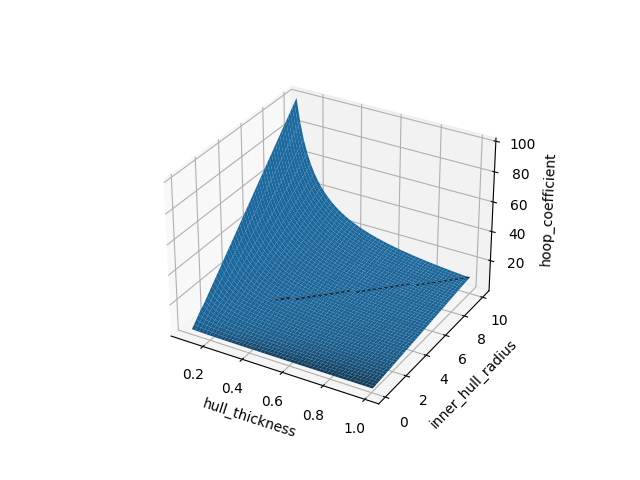

In [16]:
fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
ax1.plot_surface(
    input_data[:, :, 0].numpy(), 
    input_data[:, :, 1].numpy(), 
    output_data[:, :, 0].numpy())
ax1.set_xlabel(func.input_names[0])
ax1.set_ylabel(func.input_names[1])
ax1.set_zlabel("hoop_coefficient")
plt.show()

In [42]:
hoop_coefficient_var = sympy.Symbol("z_hoop_coefficient_var")
func2 = SympyFunc([hoop_coefficient - hoop_coefficient_var])
print(func2.input_names, func2.input_size, func2.output_size)

input_data2 = torch.cat((input_data, torch.zeros(input_data.shape[:-1]).unsqueeze(dim=-1)), dim=-1)
#input_data2 = torch.cat((input_data, output_data), dim=-1)
print(input_data2.shape)
input_data3 = newton_raphson(func2, input_data2, num_iter=2, epsilon=1e-10)


['hull_thickness', 'inner_hull_radius', 'z_hoop_coefficient_var'] 3 1
torch.Size([50, 50, 3])


<IPython.core.display.Javascript object>


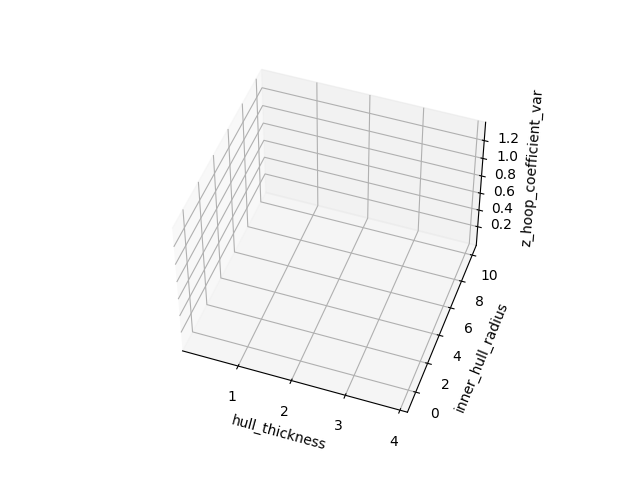

In [43]:
fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
ax1.plot_surface(
    input_data3[:, :, 0].numpy(), 
    input_data3[:, :, 1].numpy(), 
    input_data3[:, :, 2].numpy())
ax1.set_xlabel(func2.input_names[0])
ax1.set_ylabel(func2.input_names[1])
ax1.set_zlabel(func2.input_names[2])
plt.show()

<IPython.core.display.Javascript object>


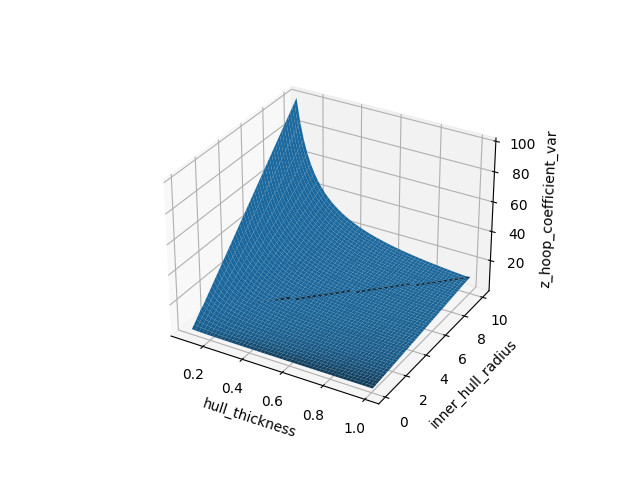

In [27]:
input_data2 = torch.cat((input_data, torch.zeros(input_data.shape[:-1]).unsqueeze(dim=-1)), dim=-1)
output_data2 = func2(input_data2)
fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
ax1.plot_surface(
    input_data2[:, :, 0].numpy(), 
    input_data2[:, :, 1].numpy(), 
    output_data2[:, :, 0].numpy())
ax1.set_xlabel(func2.input_names[0])
ax1.set_ylabel(func2.input_names[1])
ax1.set_zlabel(func2.input_names[2])
plt.show()

In [34]:
print(func2.input_names)
print(input_data2[0, 49], output_data[0, 49])
print(jacobian(func2, input_data2[0, 49]))

['hull_thickness', 'inner_hull_radius', 'z_hoop_coefficient_var']
tensor([ 0.1000, 10.0000,  0.0000]) tensor([100.])
(tensor([100.]), tensor([[-999.9999,   10.0000,   -1.0000]]))


In [41]:
100.0 * pseudo_inverse(torch.tensor([[-999.9999,   10.0000,   -1.0000]]))

tensor([[-9.9990e-02],
        [ 9.9990e-04],
        [-9.9990e-05]])

In [53]:
inner_hull_radius = 5.0
hull_thickness = sympy.Symbol("hull_thickness")  # m

outer_hull_radius = inner_hull_radius + hull_thickness
hull_thickness = outer_hull_radius - inner_hull_radius  # m
thin_hoop_condition = hull_thickness < 0.1 * inner_hull_radius  # bool
thin_hoop_coefficient = inner_hull_radius / hull_thickness
thick_hoop_coefficient = (outer_hull_radius ** 2 + inner_hull_radius ** 2) / \
    (outer_hull_radius ** 2 - inner_hull_radius ** 2)
hoop_coefficient = sympy.Piecewise(
    (thin_hoop_coefficient, thin_hoop_condition),
    (thick_hoop_coefficient, True))

<IPython.core.display.Javascript object>


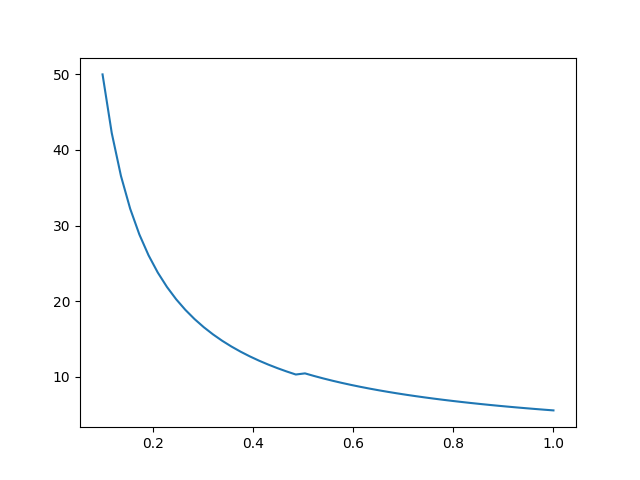

In [56]:
func3 = SympyFunc([hoop_coefficient])
input_data = torch.linspace(0.1, 1.0, 50).unsqueeze(dim=-1)
output_data = func3(input_data)

fig, ax1 = plt.subplots()
ax1.plot(input_data.squeeze(dim=-1).numpy(), output_data.squeeze(dim=-1).numpy())
fig.show()

In [74]:
inner_hull_diameter = sympy.Symbol("inner_hull_diamater")  # m
outer_hull_diameter = sympy.Symbol("outer_hull_diameter")  # m

inner_hull_radius = 0.5 * inner_hull_diameter  # m
outer_hull_radius = 0.5 * outer_hull_diameter  # m
hull_thickness = outer_hull_radius - inner_hull_radius  # m

thin_hoop_coefficient = sympy.Symbol("thin_hoop_coefficient")
thin_hoop_equation = sympy.Eq(
    thin_hoop_coefficient * hull_thickness, inner_hull_radius)

func = SympyFunc([thin_hoop_equation])
print(func.input_names)

['inner_hull_diamater', 'outer_hull_diameter', 'thin_hoop_coefficient']


<IPython.core.display.Javascript object>


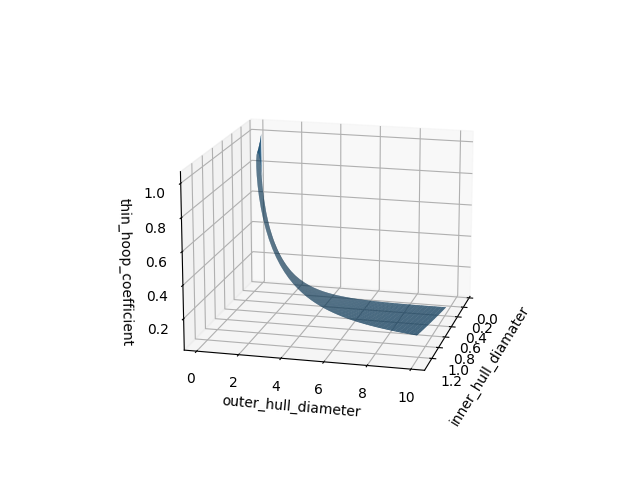

In [118]:
input_data = torch.stack(torch.meshgrid(
        torch.linspace(0.1, 1.0, 50),
        torch.linspace(0.1, 10.0, 50),
        torch.linspace(1.0, 1.0, 1)), dim=-1).squeeze(dim=2)
optim_data = newton_raphson(func, input_data, num_iter=2, epsilon=0.1)
output_data = func(optim_data)

fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
ax1.plot_surface(
    optim_data[:, :, 0].numpy(), 
    optim_data[:, :, 1].numpy(), 
    optim_data[:, :, 2].numpy())
#    output_data[:, :, 0].numpy())
ax1.set_xlabel(func.input_names[0])
ax1.set_ylabel(func.input_names[1])
ax1.set_zlabel(func.input_names[2])
plt.show()